<a href="https://colab.research.google.com/github/lakatosgabor/netalive-ollama-it-qa/blob/main/NETALive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Csomagok telepítése és importálása

In [ ]:
!sudo apt install pciutils
!pip install -q crewai
!pip install -U langchain-ollama
!pip install -qq pyngrok ollama
!curl -fsSL https://ollama.com/install.sh | sh
!pip install pytesseract
!pip install pdf2image
!sudo apt install poppler-utils
!apt-get install -y tesseract-ocr tesseract-ocr-hun
!pip install transformers torch

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt

from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image

import seaborn as sns

from pyngrok import ngrok
import requests
import json
import pandas as pd
from langchain_ollama import OllamaLLM
import subprocess

from PIL import Image
from transformers import ColQwen2ForRetrieval, ColQwen2Processor
from transformers.utils.import_utils import is_flash_attn_2_available
import pytesseract
import IPython
from typing import Any, Dict, List, Optional
from sentence_transformers import SentenceTransformer
from pdf2image import convert_from_path
import os

os.environ["OLLAMA_NUM_GPU_LAYERS"] = "100"

!nvidia-smi

Tue Dec  9 16:29:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   45C    P8             16W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Tokenizálás, vektor előállítás


In [3]:
model_name = "NYTK/husst-puli-bert-large-hungarian"   #NYTK/hucola-puli-bert-large-hungarian NYTK/husst-puli-bert-large-hungarian NYTK/hurte-puli-bert-large-hungarian
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [4]:
texts = [
    "A hálózati jogosultságot, az IT vezetőtől kell igényelni.",
    "Hol kell igényelni hozzáférést a hálózati jogosultsághoz?",
    "A nagymamám sütött egy finom almás pitét a hétvégén."
]

In [6]:
# Szövegek beágyazása és tokenek
text_embeddings = []

for text in texts:
    # Tokenizálás (512 db token)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=False)

    # Token ID-k szöveges formában
    token_ids = inputs["input_ids"][0]
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    print(f"Szöveg: {text}")
    print(f"Tokenek: {tokens}\n")

    # Modell kimenet
    with torch.no_grad():
        outputs = model(**inputs)

    # Az utolsó réteg kimenetét használjuk vektorokként
    vector = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    text_embeddings.append(vector)


Szöveg: A hálózati jogosultságot, az IT vezetőtől kell igényelni.
Tokenek: ['[CLS]', 'A', 'hálózati', 'jogosultság', '##ot', ',', 'az', 'IT', 'vezető', '##től', 'kell', 'igényel', '##ni', '.', '[SEP]']

Szöveg: Hol kell igényelni hozzáférést a hálózati jogosultsághoz?
Tokenek: ['[CLS]', 'Hol', 'kell', 'igényel', '##ni', 'hozzáférést', 'a', 'hálózati', 'jogosultság', '##hoz', '?', '[SEP]']

Szöveg: A nagymamám sütött egy finom almás pitét a hétvégén.
Tokenek: ['[CLS]', 'A', 'nagymam', '##ám', 'süt', '##ött', 'egy', 'finom', 'alm', '##ás', 'pit', '##ét', 'a', 'hétvégén', '.', '[SEP]']



A hálózati jogosultságot, az IT vezetőtől kell igényelni.
Hol kell igényelni hozzáférést a hálózati jogosultsághoz?
A nagymamám sütött egy finom almás pitét a hétvégén.


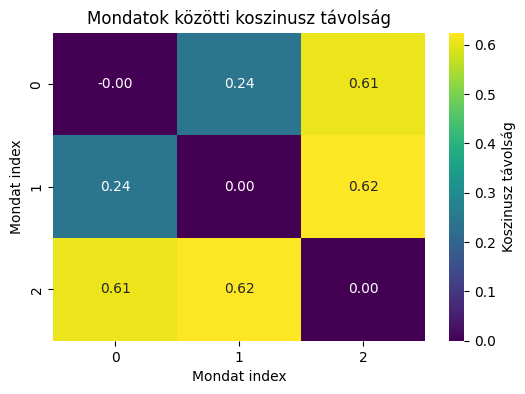

In [7]:
# Koszinusz távolság függvény
def cosine_distance(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    distance = 1 - similarity
    return distance

# Távolságmátrix létrehozása
n = len(text_embeddings)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        distance_matrix[i, j] = cosine_distance(text_embeddings[i], text_embeddings[j])

for sen in texts:
  print(sen)

# Heatmap megjelenítése indexekkel
indices = list(range(n))
plt.figure(figsize=(6, 4))
sns.heatmap(distance_matrix,
            xticklabels=indices,
            yticklabels=indices,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            cbar_kws={'label': 'Koszinusz távolság'})
plt.title("Mondatok közötti koszinusz távolság")
plt.xlabel("Mondat index")
plt.ylabel("Mondat index")
plt.show()

### Szerver indítás

In [8]:
def start_ollama_server():
    subprocess.Popen(['ollama', 'serve'])

def setup_ngrok_tunnel(port: str):
    ngrok_auth_token = "30PNgTX5ijqAbIicSn0ZHwEOOLU_3hQRpPf6wKHW25mTj462b"
    ngrok.set_auth_token(ngrok_auth_token)
    tunnel = ngrok.connect(port, host_header=f'localhost:{port}')
    print(f"ngrok tunnel created: {tunnel.public_url}")
    return tunnel

In [9]:
NGROK_PORT = '11434'
ngrok_tunnel = setup_ngrok_tunnel(NGROK_PORT)

ngrok tunnel created: https://74f957745d97.ngrok-free.app


In [10]:
start_ollama_server()

In [11]:
!ollama pull qwen3:14b

### QWEN modell betöltés

In [12]:
model_name="vidore/colqwen2-v1.0-hf"
search_model = ColQwen2ForRetrieval.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2" if is_flash_attn_2_available() else "sdpa",
)
processor = ColQwen2Processor.from_pretrained(model_name)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [44]:
generative_model="qwen3:14b"
llm = OllamaLLM(
    model=generative_model,
    temperature=0.0,
    top_p=0.9,
    num_ctx=8192,
    base_url="https://74f957745d97.ngrok-free.app"
)

### IT biztonsági anyag feldolgozása

In [14]:
pdf_path = "/content/drive/MyDrive/NETALive/it_biztonsag.pdf"

output_folder = "output_pages"
os.makedirs(output_folder, exist_ok=True)

pages = convert_from_path(pdf_path, dpi=300)

for i, page in enumerate(pages, start=1):
    output_path = os.path.join(output_folder, f"page_{i}.png")
    page.save(output_path, "PNG")
    print(f"Saved: {output_path}")

print("PDF konvertálás kész!")

Saved: output_pages/page_1.png
Saved: output_pages/page_2.png
Saved: output_pages/page_3.png
Saved: output_pages/page_4.png
Saved: output_pages/page_5.png
Saved: output_pages/page_6.png
Saved: output_pages/page_7.png
Saved: output_pages/page_8.png
Saved: output_pages/page_9.png
Saved: output_pages/page_10.png
Saved: output_pages/page_11.png
Saved: output_pages/page_12.png
Saved: output_pages/page_13.png
Saved: output_pages/page_14.png
Saved: output_pages/page_15.png
Saved: output_pages/page_16.png
Saved: output_pages/page_17.png
Saved: output_pages/page_18.png
Saved: output_pages/page_19.png
PDF konvertálás kész!


In [28]:
user_question = '''Keresd meg a dokumentumban azt a részt, amely a biztonságos
                jelszó használatról szól!'''

In [29]:
images = []
for file_name in sorted(os.listdir(output_folder)):
    if file_name.lower().endswith(".png"):
        img_path = os.path.join(output_folder, file_name)
        images.append(Image.open(img_path))

print(f"{len(images)} images loaded from '{output_folder}'.")

inputs_images = processor(images=images).to(search_model.device)
inputs_text = processor(text=user_question).to(search_model.device)

with torch.no_grad():
    image_embeddings = search_model(**inputs_images).embeddings
    query_embeddings = search_model(**inputs_text).embeddings

scores = processor.score_retrieval(query_embeddings, image_embeddings)

print("Retrieval scores (query x image):")
print(scores)

19 images loaded from 'output_pages'.
Retrieval scores (query x image):
tensor([[24.1250, 23.6250, 23.5000, 22.2500, 22.5000, 23.0000, 22.8750, 23.5000,
         23.0000, 22.3750, 23.1250, 22.7500, 23.0000, 23.6250, 24.5000, 23.2500,
         24.0000, 23.2500, 22.0000]], dtype=torch.bfloat16)


In [30]:
# Legjobb 3 kép indexének kiválasztása
top_k = 3
top_scores, top_indices = torch.topk(scores[0], k=top_k)

# OCR a top 3 képen
texts = []
for idx in top_indices:
    img = images[idx]
    text = pytesseract.image_to_string(img, lang='hun')
    texts.append(text)

# Eredmények kiírása
for i, text in enumerate(texts, 1):
    print(text)


IT biztonság közérthetően

 

a többször használatos jelszó: egyszer megaduk adott rendszerben, majd a következő
jelszóváltoztatásig ezt a jelszót használjuk,

a egyszer használatos jelszó (OTP - One Time Password): ezt a jelszót vagy a felhasz-
náló saját maga generálja és a generálás után csupán egyetlen egyszer használhatja
fel - jellemzően egy token, hardveres eszköz szükséges hozzá, vagy azon rendszer
állítja elő, ahová belépni szándékozunk és valamilyen csatornán eljuttatja hozzánk -
ennek legékesebb példája a bankok internetbankolás során alkalmazott belépési
SMS jelszava, illetve tranzakció hitelesítő SMS jelszava,

a  biometriai jelszó: az ember valamely fiziológiai jellemzője (pl. ujjlenyomat, hang, re-
tina, tenyérlenyomat stb.).

A rossz jelszavak nem nyújtanak biztonságot, hiszen a potenciális támadót nem tudják meg-
állítani, legfeljebb egy-két pillanattal tudják késleltetni a támadás bekövetkezését, mert a
rossz jelszavak feltörését vagy kitalálását másodpercek alatt el 

In [31]:
user_question = "Hogyan tartsam megfelelő biztonságban a jelszavaimat?"

prompt = f"""
    SYSTEM:
    Te egy segítőkész és szigorú IT-biztonsági szakértő vagy.
    A kérdésekre kizárólag a megadott „Forrásanyag” tartalma alapján válaszolj.
    Ne használj háttértudást, ne találj ki információt.
    Ha a válasz NINCS benne a forrásanyagban, akkor pontosan ezt írd:
    "Nincs elérhető információ, keresse az IT vezetőt."

    FORRÁSANYAG:
    ---------------------
    {texts}
    ---------------------

    FELHASZNÁLÓ KÉRDÉSE:
    {user_question}

    VÁLASZ:
    """

answer = ""
for chunk in llm.stream(prompt):
    print(chunk, end="")
    answer += chunk

A jelszavainak megfelelő biztonságban tartásához figyelembe kell venni az alábbi ajánlásokat a forrásanyag alapján:  
1. **Erős jelszóválasztás**:  
   - Legalább 8-15 karakter hosszú legyen.  
   - Tartalmazzon kis- és nagybetűket, számokat, valamint egyéb karaktereket.  
   - Kerülje a könnyen kitalálható, felhasználóra utaló adatokat (pl. születési év, házikedvenc neve).  
   - Ne használjon ismert, gyenge jelszavakat (pl. „123456”).  

2. **Jelszókezelés**:  
   - Ne használja ugyanazt a jelszót több alkalmazásban sem.  
   - Ne tárolja nyílt szöveges állományokban (pl. Excel, papíron).  

3. **Jelszószéf alkalmazások**:  
   - Használjon jelszószéfet (pl. KeePass), amely titkosított adatállományban tárolja a jelszavakat.  
   - A **mesterjelszó** (Master Password) legyen erős és ne felejtse el.  
   - Tárolja a jelszószéf adatállományát biztonságos helyen, és készítsen mentést.  

4. **Kiegészítő biztonsági intézkedések**:  
   - Használja az **egyszer használatos jelszót (OTP)**,

In [32]:
user_question = 'Mi az a jelszó széf?'
prompt = f"""
    SYSTEM:
    Te egy segítőkész és szigorú IT-biztonsági szakértő vagy.
    A kérdésekre kizárólag a megadott „Forrásanyag” tartalma alapján válaszolj.
    Ne használj háttértudást, ne találj ki információt.
    Ha a válasz NINCS benne a forrásanyagban, akkor pontosan ezt írd:
    "Nincs elérhető információ, keresse az IT vezetőt."

    FORRÁSANYAG:
    ---------------------
    {texts}
    ---------------------

    FELHASZNÁLÓ KÉRDÉSE:
    {user_question}

    VÁLASZ:
    """

answer = ""
for chunk in llm.stream(prompt):
    print(chunk, end="")
    answer += chunk

A **jelszószéf** olyan alkalmazás, amely titkosított adatállományban tárolja a felhasználók által használt jelszavakat és hozzájuk kapcsolódó információkat (pl. weboldal, felhasználónév, jelszólejárat, megjegyzés). A jelszószéfek célja, hogy biztonságosan kezelje a jelszavakat, és megkönnyítse azok használatát.  

Fontos szempontok:  
- A **mesterjelszó** (Master Password) kellően erős és ne felejthető el, mert ez a hozzáférés kulcsa a tárolt jelszavakhoz.  
- A titkosított adatokat tároló fájl mentése szükséges, mert ha elveszlik, nem lehet visszanyerni a jelszavakat.  

Példa: A **KeePass** nyílt forráskódú, ingyenes jelszószéf alkalmazás, amely erős titkosítással védi az adatokat, jelszógenerálást támogat, és tartalmaz jelszóerősség-mérőt. Egy hasznos tulajdonsága, hogy a másolt jelszó pár másodpercen belül törlődik a vágólapról.  

A munkahelyi környezetben céges szabályoknak megfelelően kell alkalmazni ilyen eszközöket.

In [33]:
user_question = 'Mit tegyek, ha ellopták a jelszavamat?'
prompt = f"""
    SYSTEM:
    Te egy segítőkész és szigorú IT-biztonsági szakértő vagy.
    A kérdésekre kizárólag a megadott „Forrásanyag” tartalma alapján válaszolj.
    Ne használj háttértudást, ne találj ki információt.
    Ha a válasz NINCS benne a forrásanyagban, akkor pontosan ezt írd:
    "Nincs elérhető információ, keresse az IT vezetőt."

    FORRÁSANYAG:
    ---------------------
    {texts}
    ---------------------

    FELHASZNÁLÓ KÉRDÉSE:
    {user_question}

    VÁLASZ:
    """

answer = ""
for chunk in llm.stream(prompt):
    print(chunk, end="")
    answer += chunk

Nincs elérhető információ, keresse az IT vezetőt.

In [34]:
user_question = 'A nagymama készített süteményt hétvégére?'
prompt = f"""
    SYSTEM:
    Te egy segítőkész és szigorú IT-biztonsági szakértő vagy.
    A kérdésekre kizárólag a megadott „Forrásanyag” tartalma alapján válaszolj.
    Ne használj háttértudást, ne találj ki információt.
    Ha a válasz NINCS benne a forrásanyagban, akkor pontosan ezt írd:
    "Nincs elérhető információ, keresse az IT vezetőt."

    FORRÁSANYAG:
    ---------------------
    {texts}
    ---------------------

    FELHASZNÁLÓ KÉRDÉSE:
    {user_question}

    VÁLASZ:
    """

answer = ""
for chunk in llm.stream(prompt):
    print(chunk, end="")
    answer += chunk

Nincs elérhető információ, keresse az IT vezetőt.